### Исследование влияния стоимости подписки на поведение пользователей дейтингового приложения

Работа идет с данными дейтингово приложения.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

Задача: проверить целесообразность применения изменения стоимости премиум-подписки для всех пользователей

Данные:

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

- users_*.csv – информация о пользователях:
- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры*1000 
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- - total_revenue – нормированная выручка 

transactions_*.csv – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

***Подготовка к работе***

Для начала подгрузим библиотеки и иходные данные, посмотрим на них 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
from scipy.stats import f_oneway
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency

In [2]:
#импортируем таблицы с данными о пользователях и транзакциях, задаем разделители, указываем на колонки с датой
users_test = pd.read_csv('Проект_3_users_test.csv', sep=';')
users_control_1 = pd.read_csv('Проект_3_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('Проект_3_users_control_2.csv', sep=';')
transactions_test = pd.read_csv('Проект_3_transactions_test.csv', sep=';', parse_dates = ['joined_at', 'paid_at'])
transactions_control_1 = pd.read_csv('Проект_3_transactions_control_1.csv', sep=';', parse_dates = ['joined_at', 'paid_at'])
transactions_control_2 = pd.read_csv('Проект_3_transactions_control_2.csv', sep=';', parse_dates = ['joined_at', 'paid_at'])

In [3]:
users_test.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0


In [4]:
transactions_test.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


Так как, согласно условию задания данные в таблицах тестовой и контрольных групп имеют одинаковую структуру, можно обьединить их в две общие таблицы с пользователями и транзакциями, добавив столбец с указанием, к какой группе относятся данные в строке.

***Предобработка данных таблицы с пользователями***

Начнем с данных о пользователях

In [5]:
users_test['group'] = 'B'
users_control_1['group'] = 'A1'
users_control_2['group'] = 'A2'

In [6]:
users = pd.concat([users_test, users_control_1, users_control_2])

In [7]:
# проверим обьем данных исходных и итоговой таблиц
users_test.shape

(4308, 14)

In [8]:
users_control_1.shape

(4340, 14)

In [9]:
users_control_2.shape

(4264, 14)

In [10]:
# размеры совпадают, мы ничего не потеряли
users.groupby('group')['uid'].count()

group
A1    4340
A2    4264
B     4308
Name: uid, dtype: int64

In [11]:
# проведем разведочный анализ данных таблицы с пользователями
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,B
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,B
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,B
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,B
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,B


In [12]:
#посчитаем количество дней посещений после регистрации для каждого пользователя
df = users.copy()
df = df.assign(visit_days=df['visit_days'].str.split(',')).explode('visit_days')
days_of_visit = df.groupby('uid')['visit_days'].count().reset_index().rename(columns={'visit_days':'days'})
users = users.merge(days_of_visit, how = 'left', on = 'uid')

In [13]:
#удалим ненужный столбец с перечислением дней
users = users.drop(columns = ['visit_days'])

In [14]:
#преобразуем данные в столбце gender к более читаемому виду
users['gender'] = users.gender.apply(lambda x: 'male' if x == 1 else 'female')

Повнимательнее изучим столбцы с информацией о том был ли клиент премиумом, или является ли им сейчас, чтобы сформировать понимание, каких клиентов мы будем относить к категории премиумов, а каких нет

In [15]:
users.was_premium.unique()

array([nan,  1.])

In [16]:
users.is_premium.unique()

array([nan,  1.])

In [17]:
users.query("was_premium == 'NaN' and is_premium == 1")

,uid,age,attraction_coeff,coins,country,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days


In [18]:
users.query("was_premium == '1' and is_premium == 1").head(3)

,uid,age,attraction_coeff,coins,country,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days
20,891152790,29,769,NaN,Spain,male,16,32,13,1.0,1.0,12597,B,3
44,891589239,21,303,37.0,Italy,male,18,24,181,1.0,1.0,37817,B,9
100,891343671,26,0,24.0,France,male,23,35,37,1.0,1.0,21580,B,9


In [19]:
users.query("was_premium == '1' and is_premium == 'NaN'").head(3)

,uid,age,attraction_coeff,coins,country,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days
4,891406035,27,1000,NaN,France,male,24,30,1,1.0,NaN,0,B,0
13,891219699,30,1000,NaN,United States of America,male,27,33,1,1.0,NaN,0,B,0
36,891348462,24,466,NaN,United States of America,male,16,36,15,1.0,NaN,0,B,0


Таким образом, столбец was_premium хранит информацию и о пользователях, которые являются премиумом в данный момент, и о пользователях подписка которых истекла. Поэтому по сути столбец is_premium дублирует неполную информацию, и его можно удалить

In [20]:
users = users.drop(columns = ['is_premium'])\
        .rename(columns={'was_premium':'premium'})
users['premium'] = users.premium.fillna(0)

In [21]:
# аналогично заменим пустые значения на 0 в столбце coins
users['coins'] = users['coins'].fillna(0)

In [22]:
users

,uid,age,attraction_coeff,coins,country,gender,age_filter_start,age_filter_end,views_count,premium,total_revenue,group,days
0,892309896,27,685,0.0,United States of America,male,24,30,89,0.0,0,B,14
1,892044516,27,0,0.0,Germany,male,24,30,0,0.0,0,B,0
2,892185708,45,44,0.0,Israel,male,42,48,68,0.0,0,B,20
3,892130292,32,0,0.0,United States of America,male,29,35,0,0.0,0,B,12
4,891406035,27,1000,0.0,France,male,24,30,1,1.0,0,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,891937401,63,242,0.0,Italy,male,50,66,33,0.0,0,A2,2
12908,891692844,35,500,0.0,France,male,24,45,2,0.0,0,A2,13
12909,891096429,41,333,0.0,United States of America,male,38,44,6,0.0,0,A2,0
12910,891697584,48,210,0.0,United Kingdom (Great Britain),male,45,51,19,0.0,0,A2,9


Исходя из условий задачи, есть три типа пользователей, те, у кого премиум подписка, те, у кого пробная версия премиум и те кто не использовал ни пробную ни премиум версии: 

In [23]:
# присвоим категории исходя из вышеназванной логики для каждого пользователя:
def user_type(premium, total_revenue):
    if premium == 1 and total_revenue > 0:
        return "pay"
    elif premium == 1 and total_revenue == 0:
        return "trial"
    else:
        return "else"

In [24]:
users['user_type'] = users.apply(lambda x: user_type(x.premium, x.total_revenue), axis = 1)

In [25]:
users.groupby('user_type')['uid'].count()

user_type
else     11657
pay        494
trial      761
Name: uid, dtype: int64

У нас в датасете были пользователи с 0 дней посещений после регистрации. Проверим, как они соотносятся с типами

In [26]:
users.query("days == 0").groupby('user_type')['uid'].count()

user_type
else     3796
pay        50
trial     172
Name: uid, dtype: int64

Логично, что больше всего людей, которые не посещают приложение после регистрации относятся к тем, кто не использует премиум подписку и ее пробную версию. 
Также в данных есть люди с пробной и с премиум подпиской, которые не посещают приложение после регистрации. Возможно не во всех случаях факт оплаты стимулирует пользователей возвращаться в приложение, либо это может быть следствием ошибки записи данных. 

В условиях задачи сказано, что изменение цены на премиум подписку произошло лишь в нескольких странах, но в каких точно, мы не знаем. Поэтому есть смысл брать в учет все страны, которые есть в тестовой группе

In [27]:
df = users.groupby(['group','country'], as_index = False).agg({'uid': 'count'})

In [28]:
pivot = df.pivot_table(index = 'country', columns='group', values='uid', fill_value=0).reset_index()

In [29]:
country = list(pivot.query('A1 != 0 and A2 != 0 and B != 0').country)

In [30]:
users = users.query('country in @country')

***Анализ данных таблицы с пользователями***

Все колонки датасета приведены в порядок, еще раз посмотрим описательную статистику:

In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12828 entries, 0 to 12911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12828 non-null  int64  
 1   age               12828 non-null  int64  
 2   attraction_coeff  12828 non-null  int64  
 3   coins             12828 non-null  float64
 4   country           12828 non-null  object 
 5   gender            12828 non-null  object 
 6   age_filter_start  12828 non-null  int64  
 7   age_filter_end    12828 non-null  int64  
 8   views_count       12828 non-null  int64  
 9   premium           12828 non-null  float64
 10  total_revenue     12828 non-null  int64  
 11  group             12828 non-null  object 
 12  days              12828 non-null  int64  
 13  user_type         12828 non-null  object 
dtypes: float64(2), int64(8), object(4)
memory usage: 1.5+ MB


In [32]:
users.describe(include='object')

,country,gender,group,user_type
count,12828,12828,12828,12828
unique,25,2,3,3
top,United States of America,male,A1,else
freq,4407,12252,4319,11579


In [33]:
users.describe(include=['float', 'int'])

,uid,age,attraction_coeff,coins,age_filter_start,age_filter_end,views_count,premium,total_revenue,days
count,1.282800e+04,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000
mean,8.917563e+08,32.010602,314.804880,9.129326,26.834347,38.560571,46.093234,0.097365,527.555971,4.532897
std,1.615224e+06,10.226745,323.369774,886.304934,9.456984,15.485199,283.676377,0.296466,5539.912796,6.202296
min,8.910509e+08,16.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913558e+08,25.000000,0.000000,0.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917248e+08,30.000000,250.000000,0.000000,25.000000,35.000000,6.000000,0.000000,0.000000,2.000000
75%,8.920853e+08,38.000000,527.000000,0.000000,32.000000,45.000000,21.000000,0.000000,0.000000,6.000000
max,1.053059e+09,99.000000,1000.000000,99958.000000,96.000000,102.000000,16157.000000,1.000000,486330.000000,31.000000


In [34]:
users.uid.nunique()

12828

В таблице содержатся данные о 12828 уникальных пользователях из 25 стран. Большая часть аудитории приходится на США. В половом соотношении приобладают мужчины

In [35]:
users.groupby(['user_type', 'gender'])['age'].describe()

count       mean        std   min    25%   50%    75%  \
user_type gender                                                            
else      female    540.0  29.229630   8.887623  16.0  23.00  28.0  33.00   
          male    11039.0  32.244859  10.285291  16.0  25.00  30.0  39.00   
pay       female     12.0  32.666667   5.989890  23.0  27.75  34.5  36.25   
          male      479.0  32.217119  10.871195  16.0  25.00  30.0  38.00   
trial     female     24.0  30.416667   7.453722  16.0  25.00  28.5  36.25   
          male      734.0  30.440054   9.519913  16.0  23.00  28.0  36.00   

                   max  
user_type gender        
else      female  99.0  
          male    99.0  
pay       female  43.0  
          male    99.0  
trial     female  44.0  
          male    62.0

Рассмотрим поподробнее информацию о возрасте пользователей разных полов с разным типом приобретенного продукта.

- в группе без подписки (наиболее многочисленной) представлены представители мужского и женского пола от 16 до 99 лет, при этом в среднем мужчины в этой группе старше женщин (медианный возраст 30 против 28 лет)
- в группе с пробной премиум подпиской представлены мужчины от 16 до 62 лет и женщины от 16 до 44 лет,  при этом в среднем женщины в этой группе немного старше мужчин (медианный возраст 28.5 против 28 лет)
- в группе с премиум подпиской представлены мужчины от 16 до 99 лет и женщины от 23 до 43 лет, при этом в среднем женщины в этой группе старше мужчин (медианный возраст 34.5 против 30 лет)

Такая ситуация может быть обусловлена тем, что с увеличением возраста женщины теряют уверенность в своей привлекательности и нуждаются в дополнительных функциях премиум-подписки, чтобы оставаться конкурентоспособными на равне с более молодыми пользовательницами

In [36]:
age = users.groupby(['user_type', 'gender'])['age'].median().reset_index()

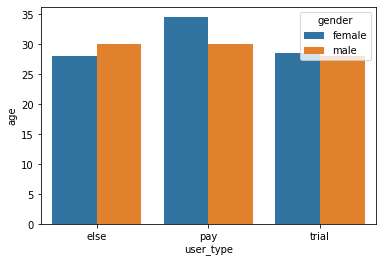

In [37]:
# медианный возраст пользователей разного пола с разным типом подписки
sns.barplot(data=age, x="user_type", y='age', hue="gender")

In [38]:
users.groupby(['user_type', 'gender'])['days'].describe()

count      mean       std  min   25%  50%    75%   max
user_type gender                                                          
else      female    540.0  3.883333  6.085911  0.0  0.00  1.0   5.00  31.0
          male    11039.0  4.290334  5.985460  0.0  0.00  2.0   6.00  31.0
pay       female     12.0  3.500000  5.468920  0.0  0.75  1.5   3.00  19.0
          male      479.0  9.607516  8.135903  0.0  3.00  8.0  16.00  31.0
trial     female     24.0  6.125000  8.522668  0.0  0.75  2.5   7.75  28.0
          male      734.0  5.311989  6.466996  0.0  1.00  3.0   8.00  30.0

In [39]:
days = users.groupby(['user_type', 'gender'])['days'].median().reset_index()

Рассмотрим поподробнее информацию о днях посещений после регистрации пользователей разных полов с разным типом приобретенного продукта.

- в группе без подписки пользователи мужского и женского пола проводят в приложении после регистрации от 0 до 31 дня, при этом в среднем мужчины в этой группе проводят в приложении больше времени, чем женщины (медианное кол-во дней 2 против 1)
- в группе с пробной премиум подпиской пользователи  женского пола проводят в приложении после регистрации от 0 до 28 дней, мужского пола - от 0 до 30 дней, при этом в среднем мужчины в этой группе проводят в приложении больше времени, чем женщины (медианное кол-во дней 3 против 2.5)
- в группе с премиум подпиской пользователи  женского пола проводят в приложении после регистрации от 0 до 19 дней, мужского пола - от 0 до 31 дней, при этом в среднем мужчины в этой группе также проводят в приложении больше времени, чем женщины (медианное кол-во дней 8 против 1.5)

При этом, в целом, прослеживается логичная тенденция, что пользователи с пробной и премиум подписками проводят в приложении  времени больше, чем пользователи без подписки

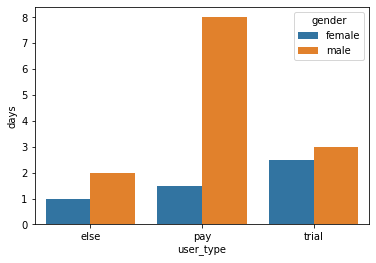

In [40]:
# медианное число дней, проведенное пользователями разного пола с разным типом подписки в приложении
sns.barplot(data=days, x="user_type", y='days', hue="gender")

In [41]:
users.groupby(['user_type', 'gender'])['views_count'].describe()

count         mean          std  min     25%    50%  \
user_type gender                                                          
else      female    540.0   460.464815   827.563086  0.0   51.00  218.5   
          male    11039.0    19.392427    74.118679  0.0    1.00    5.0   
pay       female     12.0  1874.833333  4515.076619  1.0  420.75  594.0   
          male      479.0   112.359081   270.952567  0.0   12.00   46.0   
trial     female     24.0  1184.333333  2619.287617  0.0  147.00  498.5   
          male      734.0    32.449591   123.893584  0.0    4.00   11.0   

                     75%      max  
user_type gender                   
else      female  482.75   7110.0  
          male     15.00   4953.0  
pay       female  835.25  16157.0  
          male    119.50   4262.0  
trial     female  887.25  12831.0  
          male     31.00   3012.0

Рассмотрим поподробнее информацию об оценках пользователей разных полов с разным типом приобретенного продукта.

- в группе без подписки значительно большее количество оценок получают женщины (медианное число оценок 218.5 против 5)
- в группе с пробной премиум подпиской сохраняется та же тенденция, при этом цисло оценок у пользователей обоих полов возрастает по сравнению с пользователями без подписки.
- в группе с премиум подпиской сохраняется та же тенденция, но количество оценок больше чем у пользователей с пробной подпиской

Это значит, что премиум подписка действительно работает. и предоставляет преимущества для своих владельцев

In [42]:
views_count = users.groupby(['user_type', 'gender'])['views_count'].median().reset_index()

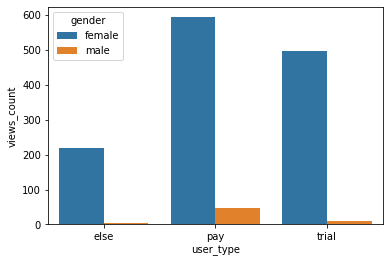

In [43]:
# медианное число оценок, полученное пользователями разного пола с разным типом подписки в приложении
sns.barplot(data=views_count, x="user_type", y='views_count', hue="gender")

In [44]:
users.groupby(['user_type', 'gender'])['attraction_coeff'].describe()

count        mean         std  min    25%    50%     75%  \
user_type gender                                                               
else      female    540.0  371.437037  262.005569  0.0  144.0  390.5  569.25   
          male    11039.0  303.460368  328.653525  0.0    0.0  200.0  500.00   
pay       female     12.0  265.250000  224.350831  0.0   62.5  241.5  411.50   
          male      479.0  359.048017  249.613274  0.0  192.0  315.0  500.00   
trial     female     24.0  338.500000  225.633601  0.0  193.0  377.5  506.00   
          male      734.0  414.919619  306.916403  0.0  166.0  400.0  639.00   

                     max  
user_type gender          
else      female  1000.0  
          male    1000.0  
pay       female   664.0  
          male    1000.0  
trial     female   708.0  
          male    1000.0

Рассмотрим поподробнее информацию об оценке привлекательности пользователей разных полов с разным типом приобретенного продукта.

- в группе без подписки коэффициент привлекательности больше у женщин (медианное число оценок 390.5 против 200)
- в группе с пробной премиум подпиской ситуация резко меняется, и коэффициент привлекательностии выше у мужчин (400 против 377.5).
- в группе с премиум подпиской сохраняется та же тенденция, причем разрыв между средним значением коэффициента привлекательности мужчин и женщин становится значительно больше в пользу мужчин

Это значит, что премиум подписка помогает мужчинам иметь более высокий коэффициент привлекательности, несмотря на то, что женщины значительно менее активно ставят им оценки (лайки)

In [45]:
attraction_coeff = users.groupby(['user_type', 'gender'])['attraction_coeff'].median().reset_index()

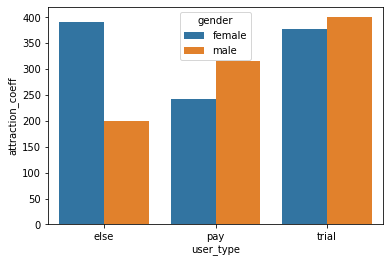

In [46]:
# медианное число оценок, полученное пользователями разного пола с разным типом подписки в приложении
sns.barplot(data=attraction_coeff, x="user_type", y='attraction_coeff', hue="gender")

In [47]:
users.groupby(['user_type', 'gender'])['coins'].describe()

count        mean          std  min  25%  50%  75%  \
user_type gender                                                         
else      female    540.0    0.037037     0.860663  0.0  0.0  0.0  0.0   
          male    11039.0    0.026814     0.783046  0.0  0.0  0.0  0.0   
pay       female     12.0    0.000000     0.000000  0.0  0.0  0.0  0.0   
          male      479.0  226.098121  4569.541085  0.0  0.0  0.0  4.0   
trial     female     24.0  353.916667  1727.874641  0.0  0.0  0.0  0.0   
          male      734.0    0.000000     0.000000  0.0  0.0  0.0  0.0   

                      max  
user_type gender           
else      female     20.0  
          male       40.0  
pay       female      0.0  
          male    99958.0  
trial     female   8466.0  
          male        0.0

Рассмотрим поподробнее информацию о наличии внутренней валюты у пользователей разных полов с разным типом приобретенного продукта.

- в группе без подписки у пользователей минимальное число монет на счету, дифференциация по половому признаку почти не заметна
- в группе с пробной премиум подпиской у мужчин монеты отсутсвуют, у женщин на счету в среднем (353.9 монет, медианное значение 0)
- в группе с премиум подпиской у женщин монеты отсутсвуют, у мужчин на счету в среднем (226 монет, медианное значение 0)

В целом больше всего монет на счетах у пользователей с премиум подпиской

In [48]:
coins = users.groupby(['user_type', 'gender'])['coins'].mean().reset_index()

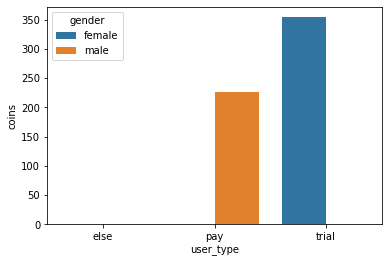

In [49]:
# среднее число монет у пользователей разного пола с разным типом подписки в приложении
sns.barplot(data=coins, x="user_type", y='coins', hue="gender")

In [50]:
users.groupby(['user_type', 'gender'])['total_revenue'].describe()

count          mean           std     min      25%  \
user_type gender                                                         
else      female    540.0      5.055556    117.480495     0.0     0.00   
          male    11039.0     16.052450    645.401219     0.0     0.00   
pay       female     12.0   9218.083333   3968.489510  3588.0  5892.25   
          male      479.0  13521.791232  25212.825238    26.0  6292.00   
trial     female     24.0      0.000000      0.000000     0.0     0.00   
          male      734.0      0.000000      0.000000     0.0     0.00   

                      50%      75%       max  
user_type gender                              
else      female      0.0      0.0    2730.0  
          male        0.0      0.0   59267.0  
pay       female   9620.0  12727.0   14352.0  
          male    10075.0  13461.5  486330.0  
trial     female      0.0      0.0       0.0  
          male        0.0      0.0       0.0

Рассмотрим поподробнее информацию о выручке с пользователей разных полов с разным типом приобретенного продукта.

- в группе без подписки выручка есть, но она невелика (в среднем 5 долларов с женщин и 16 - с мужчин)
- в группе с пробной премиум подпиской выручка отсутсвует, т.к. это бесплатный период
- в группе с премиум подпиской выручка с женщин составляет в среднем 9218 долларов (медианное значение 9620 доллара), с мужчин - 13521.8 доллара (медианное значение 10075 долларов)

Ожидаемо, основная выручка приходит от пользователей с премиум подпиской. Больше в приложении тратят мужчины чем женщины

In [51]:
total_revenue = users.groupby(['user_type', 'gender'])['total_revenue'].median().reset_index()

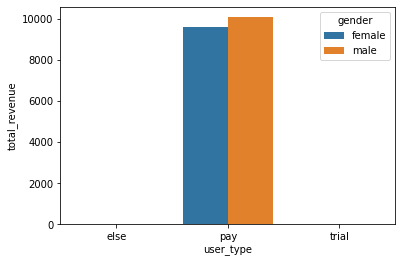

In [52]:
# медианная выручка с пользователей разного пола с разным типом подписки в приложении
sns.barplot(data=total_revenue, x="user_type", y='total_revenue', hue="gender")

***Предобработка данных таблицы с транзакциями***

Теперь вернемся к таблицам с данными о транзакциях. Объединим их по аналогии с тадицами о пользователях, присвоив колонку с информацией о том, к какой группе они относятся

In [53]:
transactions_test['group'] = 'B'
transactions_control_1['group'] = 'A1'
transactions_control_2['group'] = 'A2'

In [54]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [55]:
# проверим размер исходных датасетов
transactions_test.shape

(273, 9)

In [56]:
transactions_control_1.shape

(1007, 9)

In [57]:
transactions_control_2.shape

(328, 9)

In [58]:
# в таблице transactions_control_1 строк значительно больше, чем записалось в датасет
transactions.groupby('group')['uid'].count()

group
A1    377
A2    328
B     273
Name: uid, dtype: int64

In [59]:
# посмотрим на таблицу - в ней есть много строк без данных, проверим сколько их 
transactions_control_1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,A1
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,A1
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,A1
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,A1
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,A1
...,...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,A1
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,A1
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,A1
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,A1


In [60]:
#получается, что в датасете transactions_control_1 строк с данными - 377, а именно столько и записалось в нашу общую таблицу, значит все ок
transactions_control_1.query("uid != 'NaN'")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,A1
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,A1
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,A1
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,A1
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,A1
...,...,...,...,...,...,...,...,...,...
372,891556971.0,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial,A1
373,892052106.0,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883.0,147.0,trial_vip_popup,trial_premium,A1
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium,A1
375,891458229.0,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305.0,19.0,menu,coins,A1


In [61]:
#проверим наличе дубликатов в сочетании юзер-платеж
transactions.loc[transactions.duplicated(subset=['uid', 'paid_at'])].shape

(705, 9)

In [62]:
#действительно, дублирование присутсвует, т.е. у одного пользователя может быть несколько одинаковых оплат, проведенных в одно время
#почистим таблицу от дубликатов
transactions.drop_duplicates(subset=['uid', 'paid_at'], inplace=True)

In [63]:
# проверим, корректно ли записывалах хронология регистрация --> платеж для пользователей
transactions.query("joined_at >= paid_at").shape

(155, 9)

In [64]:
# оказывается, есть 155 записей, где платеж записался раньше регистрации. перезапишем датасет без этих ошибочных  данных
transactions = transactions.query("joined_at <= paid_at")

In [65]:
#в предыдущей итерации проекта были обнаружены три записи, датируемые 2015 годом, что значительно раньше начала проведения теста, уберем их из датасета
transactions = transactions.query("joined_at >= '2017-01-01 00:00:01'")

Согласно условию: "для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы". Отберем только пользователей с реальной премиум подпиской, и посмотрим, как обстоят дела с распределением платежей по платежным системам

In [66]:
transactions.query("product_type == 'premium_no_trial'").groupby('payment_id').count()

,uid,country,joined_at,paid_at,revenue,from_page,product_type,group
payment_id,,,,,,,,
0.0,2,2,2,2,2,2,2,2
68.0,38,38,38,38,38,38,38,38
147.0,212,212,212,212,212,212,212,212


In [67]:
transactions.payment_id.unique()

array([147.,  67.,  19., 146.,  68., 127.,   0.])

Всего есть 7 платежных систем, но в категории пользователей с премиум подпиской - три. Причем у одной из них с кодом '0' - всего две записи, исходя из кода и малого кол-ва записей - это также похоже на баг в данных, уберем эти две записи из датасета

In [68]:
transactions = transactions.query("payment_id != '0.0'")

***Анализ данных таблицы с транзакциями***

In [69]:
# посмотрим на данные
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,B
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,B
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,B
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,B
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,B


In [70]:
transactions.shape

(742, 9)

In [71]:
transactions.uid.nunique()

448

Ожидаемо, каждый пользователь совершает по несколько транзакций.

In [72]:
transactions.revenue.sum()

5411445.0

In [73]:
users.total_revenue.sum()

6767488

Интересно, что сумма выручки в таблице transactions не бьется с аналогичной суммой в users. Но, так как столбец в users носит название total_revenue, возможно туда уже заложены операционные расходы, поэтому далее будем работать с ним.

In [74]:
# проанализируем колонки со временем
transactions.describe(include='datetime64')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,joined_at,paid_at
count,742,742
unique,447,735
top,2017-10-16 01:38:00,2017-10-11 01:18:00
freq,15,2
first,2017-01-11 01:06:00,2017-01-11 05:16:00
last,2017-10-31 23:40:00,2017-12-11 23:28:00


In [75]:
transactions.sort_values(['joined_at', 'paid_at'])

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
342,891561825.0,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913.0,146.0,empty_likes,coins,A1
368,891561825.0,France,2017-01-11 01:06:00,2017-04-11 23:21:00,3900.0,19.0,empty_likes,coins,A1
196,891561825.0,France,2017-01-11 01:06:00,2017-08-11 03:06:00,12636.0,147.0,trial_vip_popup,trial_premium,A1
6,891558921.0,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100.0,147.0,left_sidebar_menu,premium_no_trial,B
43,891558921.0,United States of America,2017-01-11 03:07:00,2017-10-11 09:08:00,897.0,146.0,menu,coins,B
...,...,...,...,...,...,...,...,...,...
121,891605694.0,Argentina,2017-10-31 05:09:00,2017-11-15 04:33:00,12597.0,147.0,popular_users_block,premium_no_trial,B
131,891603810.0,United States of America,2017-10-31 06:36:00,2017-10-31 06:52:00,4602.0,146.0,menu,coins,B
210,891589239.0,Italy,2017-10-31 14:16:00,2017-10-31 14:21:00,6305.0,19.0,empty_likes,coins,B
191,891589239.0,Italy,2017-10-31 14:16:00,2017-10-31 16:07:00,12597.0,147.0,popular_users_chat,premium_no_trial,B


Первый пользователь зарегистрировался в приложении 11 января 2016 года, последний пользователь, попавший в выборку, зарегистрировался 31 октября 2017 года.  Платежи совершались в аналогичный временной промежуток. Т.е. эксперимент длился 10 месяцев и 20 дней

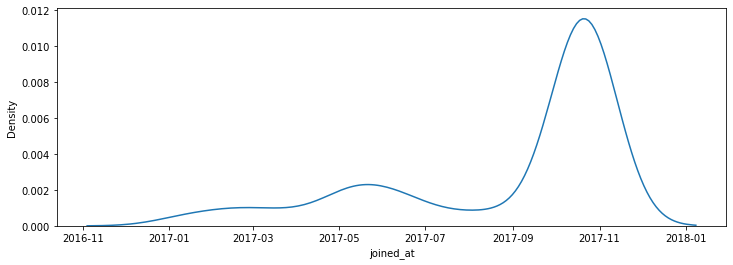

In [76]:
plt.figure(figsize=(12, 4))
sns.kdeplot(data=transactions, x="joined_at")

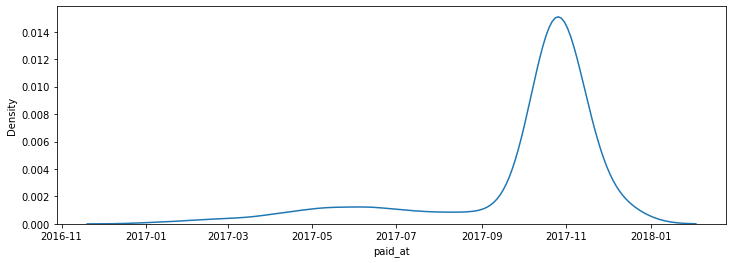

In [77]:
plt.figure(figsize=(12, 4))
sns.kdeplot(data=transactions, x="paid_at")

Посмотрим на суммы транзакций по выявленным нами платежным системам, в которых, по условию задания произошли изменения в цене.
Не очень ясно, если приложение в основном ориентировано на подписки, и плата за них списывается ежемесячно, почему сумма транзакций такая разная. 

In [78]:
transactions.query("(group == 'A1') & (payment_id == '147.0') | (payment_id == '68.0')").groupby(['revenue', 'payment_id'], as_index = False).uid.count().rename(columns={'uid':'occurrence', 'revenue':'value'})\
            .sort_values('occurrence', ascending = False).head()

,value,payment_id,occurrence
39,6292.0,147.0,35
51,9087.0,147.0,12
70,12727.0,147.0,9
28,4537.0,147.0,8
3,1898.0,68.0,4


In [79]:
transactions.query("(group == 'A2') & (payment_id == '147.0') | (payment_id == '68.0')").groupby(['revenue', 'payment_id'], as_index = False).uid.count().rename(columns={'uid':'occurrence', 'revenue':'value'})\
            .sort_values('occurrence', ascending = False).head()

,value,payment_id,occurrence
38,6292.0,147.0,36
26,4537.0,147.0,12
70,12727.0,147.0,7
54,9087.0,147.0,5
3,1898.0,68.0,4


In [80]:
transactions.query("(group == 'B') & (payment_id == '147.0') | (payment_id == '68.0')").groupby(['revenue', 'payment_id'], as_index = False).uid.count().rename(columns={'uid':'occurrence', 'revenue':'value'})\
            .sort_values('occurrence', ascending = False).head()

,value,payment_id,occurrence
64,12597.0,147.0,14
65,12727.0,147.0,12
50,9087.0,147.0,5
51,9100.0,147.0,5
32,6292.0,147.0,5


Как видно из обзора наиболее часто встречающихся сумм платежей по группам, есть несколько наиболее часто встречающихся сумм, и есть множество разовых сумм транзакций. Также видно, что в тестовой группе по сравнению с контрольными стоимость платежей выросла, но частота - снизилась

Таким образом - по таблице с транзакциями можно сделать следующие выводы:
 - после очистки данных от багов в таблице осталось 448 уникальных пользователей
 - в среднем на одного пользователя приходится 1.66 операций по оплате
 - эксперимент проводился в течении 10 месяцев 20 дней, с 11.01 по 31.10 2017 года
 - суммы транзакций не фиксированные, поэтому не похоже, что подписка оплачивается ежемесячно фиксированным платежом, возможно реализован механизм постоплаты
 - в дальнейшем для расчета метрик и проверки гипотез предлагается работать с таблицей пользователей, т.к. там есть все необходимые для этого данные

***Определение ключевых метрик для решения бизнес-вопроса***

Основной задачей проекта является проверка успешности эксперимента. Чтобы сделать это, можно сравнить несколько метрик у тестовой и контрольных групп и сделать выводы, являются ли различия статистически значимыми. В качестве метрик в данном случае можно взять:

1) ARPU - для оценки средней выручки одного пользователя

2) ARPPU - для оценки средней выручки одного платящего пользователя

3) Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта

Для расчета нам потребуются данные о суммарной выручке, общем числе пользователей, о суммарной выручке платящих пользователей, и о их кол-ве, а также о кол-ве пользователей с премиум аккаунтом и без. Все эти данные есть в таблице users, соответсвенно, далее будем работать с ней

***АА - тестирование***

У нас есть две контрольные группы, поэтому можно, перед началом расчета метрик и AB тестирования, проверить AA тестом, что пользователи распределяются по группам примерно равномерно по кол-ву пользователей из одинаковых стран, а также с одинаковым соотношением мужчин и женщин

In [81]:
AA = users.query("group == 'A1' or group == 'A2'").groupby(['country', 'group'], as_index=False).agg({'uid': 'count'})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

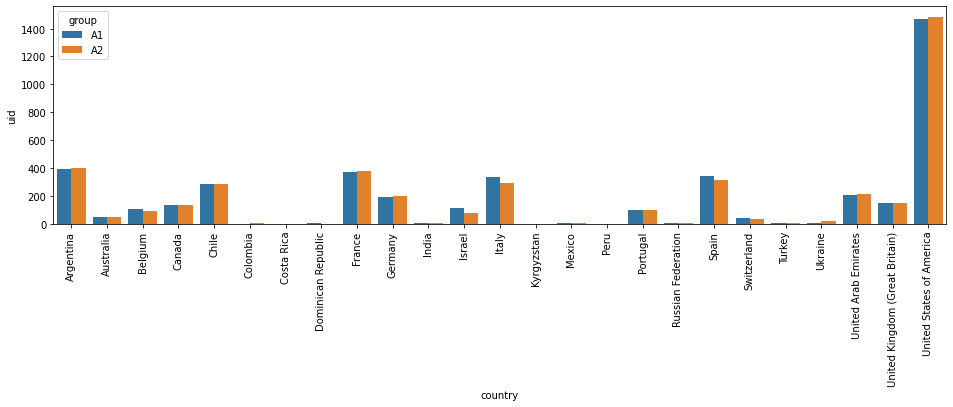

In [82]:
plt.figure(figsize=(16, 4))
sns.barplot(data=AA, x="country", y='uid', hue="group")
plt.xticks(rotation=90)

Визуально соотношение представителей разных стран в группах почти одинаково.

А теперь проверим наше предположение о том что люди из разных стран представлены в группах в примерно одинаковом соотношении с помощью статистического теста.

Так как данные категориальные, можно использовать тест хи-квадрат для сравнения двух контрольных групп по количеству людей из разных стран. Хи-квадрат используется для определения наличия статистически значимых различий между наблюдаемыми и ожидаемыми частотами в категориальных данных.

Нулевая гипотеза (H0): Распределение количества людей из разных стран в двух контрольных группах одинаково.

Альтернативная гипотеза (H1): Распределение количества людей из разных стран в двух контрольных группах различно.

In [83]:
crosstab_AA = pd.crosstab(users.country, users.query("group == 'A1' or group == 'A2'").group)

In [84]:
chi2_contingency(crosstab_AA)

(19.67563418349905,
 0.7150646133475089,
 24,
 array([[3.96720112e+02, 3.89279888e+02],
        [5.09780297e+01, 5.00219703e+01],
        [9.99371275e+01, 9.80628725e+01],
        [1.35268435e+02, 1.32731565e+02],
        [2.89211990e+02, 2.83788010e+02],
        [1.51419890e+00, 1.48580110e+00],
        [1.00946593e+00, 9.90534066e-01],
        [1.51419890e+00, 1.48580110e+00],
        [3.76530794e+02, 3.69469206e+02],
        [1.96845857e+02, 1.93154143e+02],
        [4.03786374e+00, 3.96213626e+00],
        [9.43850649e+01, 9.26149351e+01],
        [3.18486502e+02, 3.12513498e+02],
        [1.00946593e+00, 9.90534066e-01],
        [4.03786374e+00, 3.96213626e+00],
        [1.00946593e+00, 9.90534066e-01],
        [1.00946593e+02, 9.90534066e+01],
        [7.06626154e+00, 6.93373846e+00],
        [3.29085895e+02, 3.22914105e+02],
        [3.88644385e+01, 3.81355615e+01],
        [6.56152857e+00, 6.43847143e+00],
        [1.31230571e+01, 1.28769429e+01],
        [2.10978380e+02, 2.070

Исходя из полученных результатов, p-значение равно 0.715, что означает, что нет статистически значимых различий между распределением количества людей из разных стран в двух контрольных группах. Следовательно, мы не можем отвергнуть нулевую гипотезу о равенстве распределений.

Проделаем тоже самое для оценки соотношения людей разных полов в группах.

In [85]:
AA1 = users.query("group == 'A1' or group == 'A2'").groupby(['gender', 'group'], as_index=False).agg({'uid': 'count'})

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

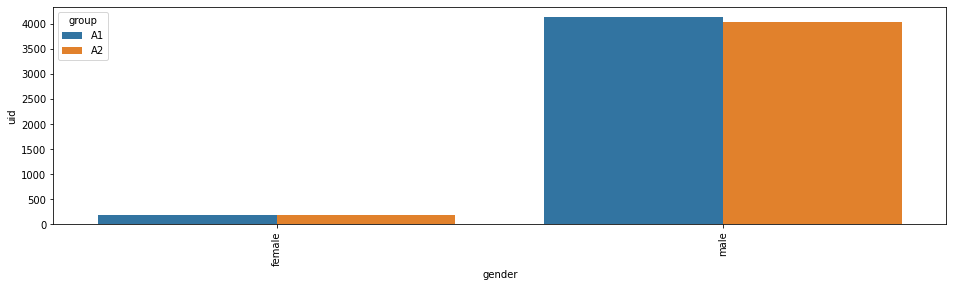

In [86]:
plt.figure(figsize=(16, 4))
sns.barplot(data=AA1, x="gender", y='uid', hue="group")
plt.xticks(rotation=90)

Визуально разница также почти не наблюдается.

Аналогично используем хи-квадрат для сравнения контрольных групп по соотношению полов: 

Нулевая гипотеза (H0): Распределение количества людей разного пола в двух контрольных группах одинаково.

Альтернативная гипотеза (H1): Распределение количества людей разного пола в двух контрольных группах различно.

In [87]:
crosstab_AA1 = pd.crosstab(users.gender, users.query("group == 'A1' or group == 'A2'").group)

In [88]:
crosstab_AA1

group,A1,A2
gender,,
female,182,194
male,4137,4044


In [89]:
chi2_contingency(crosstab_AA1)

(0.589713019210922,
 0.4425301138655652,
 1,
 array([[ 189.77959565,  186.22040435],
        [4129.22040435, 4051.77959565]]))

Исходя из полученных результатов, p-значение равно 0.44, что означает, что нет статистически значимых различий между распределением количества людей разного пола в двух контрольных группах. Следовательно, мы не можем отвергнуть нулевую гипотезу о равенстве распределений.

Таким образом, распределение людей в контрольных группах не имеет статистически значимых различий, и система деления на группы работает корректно. Поэтому, дабы избежать большой разницы в размерах контрольной и тесторой выборок - для проведения АБ теста оставим только одну контрольную группу -  А2, т.к. ее размер ближе к тестовой 

In [90]:
users.groupby('group').uid.count()

group
A1    4319
A2    4238
B     4271
Name: uid, dtype: int64

In [91]:
users = users.query("group != 'A1'")

***АВ - тестирование***

###### ARPU

Рассчитаем  ARPU - для оценки средней выручки одного пользователя и проверим, есть ли разница между контрольной и тестовой группами, и является ли она статистически значимой

Надо оценить получившиеся данные на соблюдение параметрических предположений, чтобы правильно подобрать статистический тест (проверить данные на нормальность распределения и равенство дисперсий). Для этого сначала построим гистограммы и посмотрим распределения визуально

In [92]:
A_revenue = users.query('group == "A2"').total_revenue.reset_index()

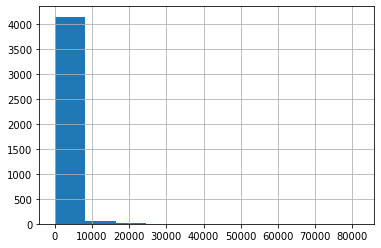

In [93]:
A_revenue.total_revenue.hist()

In [94]:
B_revenue = users.query('group == "B"').total_revenue.reset_index()

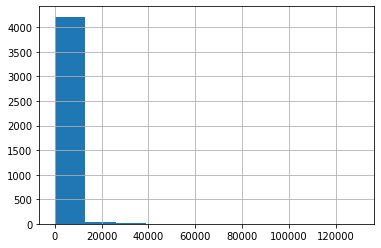

In [95]:
B_revenue.total_revenue.hist()

Данные в контрольной и тестовой группах не похожи на нормальное распределение. Для большей уверенности проверим обе группы на нормальность тестом Шапиро-Уилка:
1. Нулевая гипотеза (H0): данные распределены нормально.
2. Альтернативная гипотеза (H1): данные не распределены нормально.

In [96]:
scipy.stats.shapiro(A_revenue.total_revenue)

ShapiroResult(statistic=0.1434062123298645, pvalue=0.0)

In [97]:
scipy.stats.shapiro(B_revenue.total_revenue)

ShapiroResult(statistic=0.0992351770401001, pvalue=0.0)

Данные в контрольной и тестовой группах распределены не нормально. Теперь проверим данные на равенство дисперсий. Для этого используем тест Фишера 

1. Нулевая гипотеза (H0): Дисперсии двух выборок равны. 
2. Альтернативная гипотеза (H1): Дисперсии двух выборок не равны. 

In [98]:
f_oneway(A_revenue.total_revenue, B_revenue.total_revenue)

F_onewayResult(statistic=1.2297132289700101, pvalue=0.26749416362803374)

Исходя из результатов теста, мы не отвергаем нулевую гипотезу - дисперсии двух выборок равны.
Для сравнения средних значений двух выборок с ненормальным распределением и равными дисперсиями можно использовать непараметрический тест Колмогорова-Смирнова, который не требует нормальности данных. 

Нулевая гипотеза (H0): Две выборки взяты из одного и того же распределения.

Альтернативная гипотеза (H1): Две выборки взяты из разных распределений.

Таким образом, при применении теста Колмогорова-Смирнова мы проверяем гипотезу о том, что две выборки имеют одинаковое распределение (нулевая гипотеза) против альтернативной гипотезы о том, что распределения выборок различны.

In [99]:
#посмотрим медианные значения суммарной выручки для пользователей,медианы равны 0 т.е. платят менее 50% пользователей
users.groupby('group').agg({'total_revenue': 'median'}).rename(columns={'total_revenue': 'median'})

,median
group,
A2,0
B,0


In [100]:
# а вот средняя выручка на одного пользователя уже есть
users.groupby('group').agg({'total_revenue': 'mean'}).rename(columns={'total_revenue': 'ARPU'})

,ARPU
group,
A2,447.263804
B,536.342074


In [101]:
ks_2samp(A_revenue.total_revenue, B_revenue.total_revenue)

KstestResult(statistic=0.010161930351308567, pvalue=0.9782617703930248)

По данным теста - ARPU статистически значимо не изменяется между тестовой и контрольной группами 

###### ARPPU

Рассчитаем ARPPU - для оценки средней выручки одного платящего пользователя и проверим, есть ли разница между контрольной и тестовой группами, и является ли она статистически значимой

Надо оценить получившиеся данные на соблюдение параметрических предположений, чтобы правильно подобрать статистический тест (проверить данные на нормальность распределения и равенство дисперсий). Для этого сначала построим гистограммы и посмотрим распределения визуально

In [102]:
A_pay_revenue = users.query('group == "A2" and total_revenue > 0').total_revenue.reset_index()

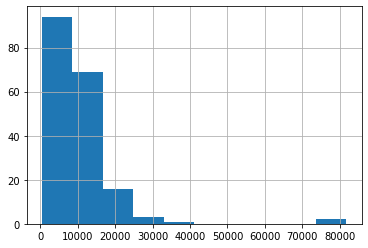

In [103]:
A_pay_revenue.total_revenue.hist()

In [104]:
B_pay_revenue = users.query('group == "B" and total_revenue > 0').total_revenue.reset_index()

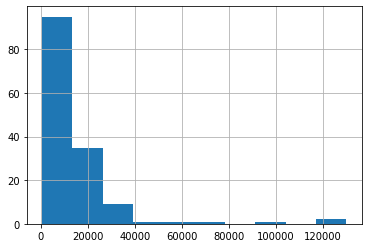

In [105]:
B_pay_revenue.total_revenue.hist()

Данные в контрольной и тестовой группах не похожи на нормальное распределение. Для большей уверенности проверим обе группы на нормальность тестом Шапиро-Уилка:
1. Нулевая гипотеза (H0): данные распределены нормально.
2. Альтернативная гипотеза (H1): данные не распределены нормально.

In [106]:
scipy.stats.shapiro(A_pay_revenue.total_revenue)

ShapiroResult(statistic=0.6249949932098389, pvalue=6.080157488358645e-20)

In [107]:
scipy.stats.shapiro(B_pay_revenue.total_revenue)

ShapiroResult(statistic=0.5507380962371826, pvalue=3.111000434417795e-19)

Данные в контрольной и тестовой группах распределены не нормально. Теперь проверим на данные на равенство дисперсий. Для этого используем тест Фишера 

1. Нулевая гипотеза (H0): Дисперсии двух выборок равны. 
2. Альтернативная гипотеза (H1): Дисперсии двух выборок не равны. 

In [108]:
f_oneway(A_pay_revenue.total_revenue, B_pay_revenue.total_revenue)

F_onewayResult(statistic=12.997227987659988, pvalue=0.000360419993475039)

Исходя из результатов теста, мы отвергаем нулевую гипотезу - дисперсии двух выборок не равны.
Для сравнения средних значений двух выборок с ненормальным распределением и неравными дисперсиями можно использовать непараметрический тест Колмогорова-Смирнова, который не требует нормальности данных. 

Нулевая гипотеза (H0): Две выборки взяты из одного и того же распределения.

Альтернативная гипотеза (H1): Две выборки взяты из разных распределений.

Таким образом, при применении теста Колмогорова-Смирнова мы проверяем гипотезу о том, что две выборки имеют одинаковое распределение (нулевая гипотеза) против альтернативной гипотезы о том, что распределения выборок различны.

In [109]:
users.query('total_revenue > 0').groupby('group').agg({'total_revenue': 'median'}).rename(columns={'total_revenue': 'median'})

,median
group,
A2,7930
B,12727


In [110]:
users.query('total_revenue > 0').groupby('group').agg({'total_revenue': 'mean'}).rename(columns={'total_revenue': 'ARPPU'})

,ARPPU
group,
A2,10245.967568
B,15798.048276


In [111]:
ks_2samp(A_pay_revenue.total_revenue, B_pay_revenue.total_revenue)

KstestResult(statistic=0.2924510717614166, pvalue=1.210348611335732e-06)

По данным теста - ARPPU статистически значимо изменяется между тестовой и контрольной группами в сторону увеличения на 24.8% в тестовой группе

###### Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта

Рассчитаем конверсию пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта. Пользователями с премиум аккаунтом будем считать тех, у кого есть статус премиум и кто заплатил за него. Всех остальных пользователей отнесем к бесплатным (хоть, как мы выяснили, пользователи без подписки и оплачивают некие услуги, но основной доход у нас все же идет от пользователей, покупающих премиум подписку).

In [112]:
users['conversion_type'] = users['user_type'].apply(lambda x: 'free' if x != 'pay' else 'pay')

Так как данные категориальные, можно использовать тест хи-квадрат, который используется для проверки независимости между двумя категориальными переменными.
1. Нулевая гипотеза (H0): нет статистически значимой связи между двумя переменными. Другими словами, переменные независимы друг от друга.
2. Альтернативная гипотеза (H1): существует статистически значимая связь между двумя переменными. То есть переменные зависимы друг от друга.

In [113]:
crosstab = pd.crosstab(users.conversion_type, users.group)

In [114]:
crosstab

group,A2,B
conversion_type,,
free,4065,4132
pay,173,139


In [115]:
chi2_contingency(crosstab)

(3.893874977730384,
 0.04846248676145216,
 1,
 array([[4082.60500646, 4114.39499354],
        [ 155.39499354,  156.60500646]]))

Согласно результатам теста, 0 гипотеза не может быть принята, соответсвенно, существует статистически значимая связь между двумя переменными

In [116]:
test_conversion = (users.query("group == 'B' and conversion_type == 'pay'").uid.count() / (users.query("group == 'B' and conversion_type == 'free'").uid.count() + users.query("group == 'B' and conversion_type == 'pay'").uid.count()))*100

In [117]:
test_conversion

3.2545071411847344

In [118]:
control_conversion = (users.query("group == 'A2' and conversion_type == 'pay'").uid.count() / (users.query("group == 'A2' and conversion_type == 'free'").uid.count() + users.query("group == 'A2' and conversion_type == 'pay'").uid.count()))*100

In [119]:
control_conversion

4.082114204813592

Таким образом, можно сделать вывод, что после увеличения стоимости премиум подписки в тестовой группе, конверсия из бесплатного пользователя в премиум статистически значимо изменилась (понизилась на 21%)

###### Заключение

Таким образом, после проведения анализа результатов A/B тестирования, можно сделать следующие выводы:

- ARPU статистически значимо не изменяется между тестовой и контрольной группами
- ARPPU статистически значимо изменяется между тестовой и контрольной группами в сторону увеличения на 24.8% в тестовой группе
- после увеличения стоимости премиум подписки в тестовой группе, конверсия из бесплатного пользователя в премиум статистически значимо изменилась (понизилась на 21%)

По итогу можно сказать следующее: наибольший рост выручки (почти на 25%) произошел в сегменте пользователей, которые ранее и так приносили деньги бизнесу, и  теперь прирост произошел вследствии непосредственно роста цены на подписку. Если посмотреть на сегмент условно 'бесплатных' пользователей, которые не платили за подписку регулярно, там изменения не оказались статистически значимыми, т.е. фактически ничего не поменялось.
Если учитывать, что конверсия из 'бесплатных' пользователей в пользователей с премиум подпиской (которые приносят основную массу денег бизнесу) после повышения цен на премиум подписку упала на 21%, можно сделать вывод, что эксперимент был скорее неудачным. И раскатывать обновление на всех пользователей не стоит.